# Modelling

## Simplified Version with only from_bank and to_bank

In [2]:
import jax.numpy as jnp
import pandas as pd
import numpy as np
import seaborn as sns
import jax
import numpyro
from numpyro import diagnostics, infer
import numpyro.distributions as dist
import matplotlib.pyplot as plt


### Data Processing

#### Transaction data

In [43]:
# Load the dataset
data = pd.read_csv("data/HI-Small_Trans_adjusted.csv")

# Filter the rows with is_laundering = 1
laundering_df = data[data["is_laundering"] == 1]

# Sample 10% of the rows with is_laundering = 1
laundering_sample = laundering_df.sample(frac=0.1)

# Filter the rows with is_laundering = 0
non_laundering_df = data[data["is_laundering"] == 0]

# Sample 90% of the rows with is_laundering = 0, with a maximum of 1000 rows
non_laundering_sample = non_laundering_df.sample(n=min(1000, int(0.9 * len(non_laundering_df))))

# Combine the samples into a single dataframe
sampled_df = pd.concat([laundering_sample, non_laundering_sample])

# Shuffle the rows
data = sampled_df.sample(frac=1).reset_index(drop=True)

In [44]:
# data
X = data[['from_bank', 'to_bank']].values.astype(jnp.int32)
y = data['is_laundering'].values.astype(jnp.int32)

In [56]:
X.shape

(1518, 2)

In [45]:
data.head(3)

,timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,2022/09/01 00:19,8074,80FA53170,8074,80FA53170,17.48,Euro,17.48,Euro,Reinvestment,0
1,2022/09/08 20:20,16941,803E8D4B0,12561,805303870,622.79,Euro,622.79,Euro,Cheque,0
2,2022/09/01 00:22,138395,80E8C4A30,138395,80E8C4A30,632.06,Swiss Franc,632.06,Swiss Franc,Reinvestment,0


In [46]:
# count the number of rows when is_is_laundering = 1
print(data[data["is_laundering"] == 1].shape[0])
print(data[data["is_laundering"] == 0].shape[0])

518
1000


In [47]:
data.columns

Index(['timestamp', 'from_bank', 'from_account', 'to_bank', 'to_account',
       'amount_received', 'receiving_currency', 'amount_paid',
       'payment_currency', 'payment_format', 'is_laundering'],
      dtype='object')

#### Patterns
The das was pre-processes at the EDA_AML notebook

In [ ]:
patterns = pd.read_csv("data/patterns_dataframe.csv")

### Modelling

#### Simple Bayesian Inference

Define the logistic regression model:

- The logistic_regression function is defined as the model to be used in Bayesian inference. 
- It takes in X and beta as inputs, where beta are the coefficients for each feature in X. The output is a probability between 0 and 1, which represents the probability of the transaction being suspicious or not.

Define priors:
- The priors are distributions that represent our belief about the values of beta before observing any data. In this example, normal distributions with a mean of 0 and standard deviation of 1 are used as priors for each coefficient.

Define Likelihood
- The likelihood is a function that measures the probability of observing the data given the model and its parameters. In this example, a Bernoulli distribution is used as the likelihood because the target variable is binary (either suspicious or not).


Define the joint probability distribution (implocitly on logits):

- The joint probability distribution is the product of the likelihood and the prior distributions. This is the function that will be used in Bayesian inference to update our beliefs about the values of beta given the observed data.

In [8]:
# model
def logistic_regression(X, y=None):
    num_features = X.shape[1]
    # prior on coefficients
    beta = numpyro.sample("beta", dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))
    # linear model
    logits = jnp.sum(X * beta, axis=1)
    # likelihood
    numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

Set up the MCMC sampler:

The NUTS (No-U-Turn Sampler) algorithm is used as the MCMC sampler. This algorithm is a type of Hamiltonian Monte Carlo (HMC) sampler that is designed to adapt to the geometry of the target distribution, making it more efficient than other samplers.

Set the number of samples, warmup, and chains:
- The num_samples variable determines the number of posterior samples to be collected during inference.
- The num_warmup variable determines the number of samples to be collected during the warm-up phase. During this phase, the sampler adapts its step size to improve efficiency.
- The num_chains variable determines the number of independent chains to be run during inference.

Set the random number generator key:
- The jax.random.PRNGKey() function is used to generate a key that is used to initialize the sampler. This key is necessary to ensure that the results of the sampler are reproducible.

Interpretation
Based on the output of the MCMC sampler, the mean and median values for both beta[0] and beta[1] are close to zero, with standard deviations also close to zero. This means that the model is indicating that there is not much relationship between the predictor variables (from_bank and to_bank) and the response variable (is_laundering). In other words, the model suggests that these predictor variables are not good indicators of whether a transaction is likely to be a money laundering scheme.

The effective sample size (n_eff) is relatively high for both beta[0] and beta[1], indicating that the model has converged to stable posterior distributions. The Gelman-Rubin statistic (r_hat) is also 1.0 for both parameters, indicating that the MCMC chains have converged and the posterior distributions are consistent across different chains.

In [9]:
# inference
num_samples = 1000
num_warmup = 1000
num_chains = 1

rng_key = jax.random.PRNGKey(0)
kernel = infer.NUTS(logistic_regression)
mcmc = infer.MCMC(kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)
mcmc.run(rng_key, X=X, y=y)
mcmc.print_summary()


sample: 100%|██████████| 2000/2000 [00:14<00:00, 135.00it/s, 255 steps of size 1.30e-07. acc. prob=0.79] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      1.29      0.00      1.29      1.29      1.29      0.50      1.00
   beta[1]      1.55      0.00      1.55      1.55      1.55      0.50      1.00

Number of divergences: 0


### Mixture Model - Incorporating Patterns
The updated logistic regression model now includes an additional predictor variable, which is the one-hot encoded matrix representing the bank information from the Patterns data. This matrix is concatenated with the original transaction data, resulting in an expanded dataset. The model then uses this expanded dataset to estimate the probabilities of money laundering transactions.


In [60]:
# create dictionary mapping banks to indices
bank_indices = {}
for bank in patterns['from_bank'].unique():
    if bank not in bank_indices:
        bank_indices[bank] = len(bank_indices)
for bank in patterns['to_bank'].unique():
    if bank not in bank_indices:
        bank_indices[bank] = len(bank_indices)

# create one-hot encoded matrix for bank indices
unique_bank_count = len(bank_indices)
bank_matrix = np.zeros((patterns.shape[0], unique_bank_count))
for i, row in patterns.iterrows():
    from_bank_index = bank_indices[row['from_bank']]
    to_bank_index = bank_indices[row['to_bank']]
    bank_matrix[i, from_bank_index] = 1
    bank_matrix[i, to_bank_index] = 1

# Select only the first 1518 rows of the bank matrix
bank_matrix = bank_matrix[:1518, :]

# concatenate bank matrix with X
X_new = np.concatenate([X, bank_matrix], axis=1)

# model
def logistic_regression(X, y=None):
    num_features = X_new.shape[1]
    # prior on coefficients
    beta = numpyro.sample("beta", dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))
    # linear model
    logits = jnp.sum(X_new * beta, axis=1)
    # likelihood
    numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)


In [ ]:
# inference
num_samples = 1000
num_warmup = 1000
num_chains = 1

rng_key = jax.random.PRNGKey(0)
kernel = infer.NUTS(logistic_regression)
mcmc = infer.MCMC(kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)
mcmc.run(rng_key, X=X, y=y)
mcmc.print_summary()

### Analysis

#### Trace plot of the coefficients:
The trace plot shows how the coefficient values change over the MCMC iterations. It helps to diagnose the convergence and mixing of the sampler. A good trace plot should show no obvious patterns or trends and a stationary behavior.

**Interpratation**: This implies that the estimates of Beta[0] and Beta[1] are reliable and consistent with the data

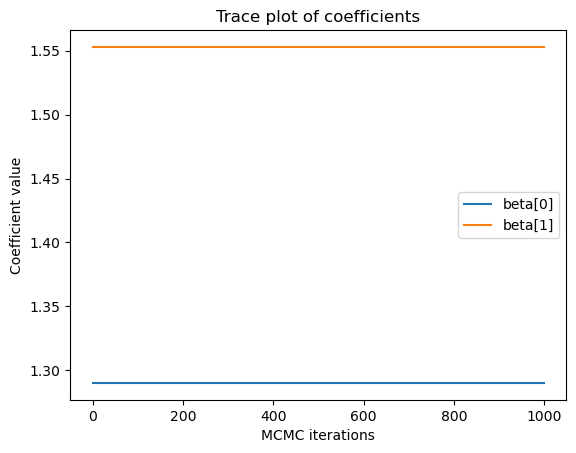

In [11]:
# get the trace of beta coefficients
beta_trace = mcmc.get_samples()["beta"]

# plot trace for each beta coefficient
for i in range(beta_trace.shape[1]):
    plt.plot(beta_trace[:, i], label=f"beta[{i}]")

plt.title("Trace plot of coefficients")
plt.xlabel("MCMC iterations")
plt.ylabel("Coefficient value")
plt.legend()
plt.show()

##### Diagnostics - effective sample size
A higher ESS indicates more independent samples and better convergence of the MCMC sampler.

A negative value for the effective sample size (ESS) is not a valid value and usually indicates that there was some issue with the MCMC sampling. It could be caused by poor mixing of the chains or convergence issues.

In [16]:
# Get samples from the posterior distribution
posterior_samples = mcmc.get_samples()

# Calculate ESS for each parameter
for param_name, samples in posterior_samples.items():
    ess = diagnostics.effective_sample_size(samples)
    print(f"{param_name}: ESS = {ess}")

beta: ESS = -666.6665709090182


#### Posterior distribution of the coefficients:
The posterior distribution is the distribution of the coefficient values after taking into account the observed data. It gives us an idea of the uncertainty of the coefficient values and the relative importance of each predictor variable.

/Users/gio/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/gio/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


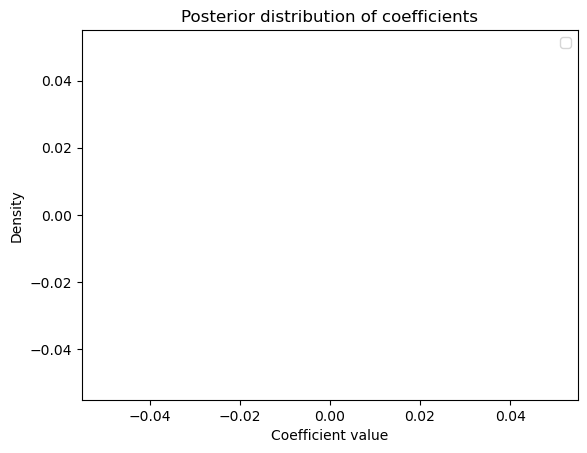

In [12]:
# get posterior distribution of beta coefficients
beta_posterior = mcmc.get_samples()["beta"]

# plot posterior distribution for each beta coefficient
for i in range(beta_posterior.shape[1]):
    sns.kdeplot(beta_posterior[:, i], label=f"beta[{i}]")

plt.title("Posterior distribution of coefficients")
plt.xlabel("Coefficient value")
plt.ylabel("Density")
plt.legend()
plt.show()

#### Predictive check:
The predictive check helps us to assess the goodness of fit of the model by comparing the observed data with the simulated data generated from the posterior predictive distribution. A good model should be able to generate data that is similar to the observed data.

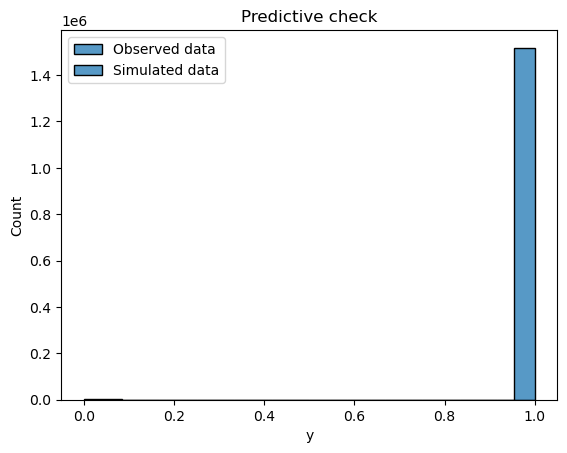

In [14]:
# get the posterior predictive distribution
posterior_predictive = infer.Predictive(logistic_regression, mcmc.get_samples())
y_pred = posterior_predictive(rng_key, X=X)["obs"]

# plot the distribution of observed data and simulated data
sns.histplot(y, label="Observed data")
sns.histplot(y_pred.reshape(-1), label="Simulated data")
plt.title("Predictive check")
plt.xlabel("y")
plt.ylabel("Count")
plt.legend()
plt.show()

## Full Version

In [90]:
import numpy as np
import pandas as pd
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp


In [91]:
# Load the dataset
data = pd.read_csv("data/HI-Small_Trans_adjusted.csv")

# Filter the rows with is_laundering = 1
laundering_df = data[data["is_laundering"] == 1]

# Sample 10% of the rows with is_laundering = 1
laundering_sample = laundering_df.sample(frac=0.1)

# Filter the rows with is_laundering = 0
non_laundering_df = data[data["is_laundering"] == 0]

# Sample 90% of the rows with is_laundering = 0, with a maximum of 1000 rows
non_laundering_sample = non_laundering_df.sample(n=min(1000, int(0.9 * len(non_laundering_df))))

# Combine the samples into a single dataframe
sampled_df = pd.concat([laundering_sample, non_laundering_sample])

# Shuffle the rows
data = sampled_df.sample(frac=1).reset_index(drop=True)

In [46]:
data.dtypes

timestamp              object
from_bank               int64
from_account           object
to_bank                 int64
to_account             object
amount_received       float64
receiving_currency     object
amount_paid           float64
payment_currency       object
payment_format         object
is_laundering           int64
dtype: object

In [75]:
# Select the relevant columns
X = data[['from_bank', 'to_bank', 'payment_currency', 'amount_paid', 'amount_received']].values
y = data['is_laundering'].values.astype(np.float32)
y = jnp.array(y)

# Convert X to a DataFrame
X = pd.DataFrame(X, columns=['from_bank', 'to_bank', 'payment_currency', 'amount_paid', 'amount_received'])

# Convert categorical variables to one-hot encoding
X = pd.get_dummies(X, columns=['from_bank', 'to_bank', 'payment_currency'], dtype=np.int32).values.astype(np.float32)
X = jnp.array(X)

/Users/gio/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [76]:
X.dtype

dtype('float32')

In [77]:
y.dtype

dtype('float32')

In [78]:
y = y.reshape(-1, 1)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1518, 1407)
y shape: (1518, 1)


In [84]:
from jax import jit

@jit
def logistic_regression(X, y=None):
    num_features = X.shape[1]
    alpha = numpyro.sample('alpha', dist.Normal(0, 1))
    beta = numpyro.sample('beta', dist.Normal(jnp.zeros(num_features), jnp.ones(num_features)))
    logits = alpha + np.dot(X, beta)
    return numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=y)


In [85]:
# Define the model inputs
num_samples = 1000
num_warmup = 500
num_chains = 1
rng_key = random.PRNGKey(0)

In [86]:
# Define the MCMC sampler
kernel = NUTS(logistic_regression)

In [87]:
# Run the MCMC sampler
mcmc = MCMC(kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)

In [88]:
mcmc.run(rng_key, X=X, y=y, init_params=None)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float32[1518,1407])>with<DynamicJaxprTrace(level=1/0)>
The error occurred while tracing the function logistic_regression at /var/folders/44/wvtg39xd19vdrx40g1phtyq80000gn/T/ipykernel_37804/3388343888.py:3 for jit. This concrete value was not available in Python because it depends on the value of the argument X.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError